In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
%matplotlib inline

In [2]:
pip install pyforest

Note: you may need to restart the kernel to use updated packages.


In [3]:
from pyforest import*
lazy_imports()

['import torch',
 'import datetime as dt',
 'from sklearn.preprocessing import RobustScaler',
 'import spacy',
 'from sklearn import svm',
 'from sklearn.impute import SimpleImputer',
 'import os',
 'import skimage',
 'from sklearn.ensemble import RandomForestClassifier',
 'import imutils',
 'import keras',
 'from sklearn.feature_extraction.text import CountVectorizer',
 'import glob',
 'from sklearn.model_selection import RandomizedSearchCV',
 'from scipy import signal as sg',
 'import sys',
 'from sklearn.linear_model import Lasso',
 'from sklearn.linear_model import LassoCV',
 'import textblob',
 'import fbprophet',
 'import re',
 'from sklearn.linear_model import RidgeCV',
 'import bokeh',
 'from sklearn.feature_extraction.text import TfidfVectorizer',
 'import tqdm',
 'from statsmodels.tsa.arima_model import ARIMA',
 'import pandas as pd',
 'from sklearn.cluster import KMeans',
 'import gensim',
 'import altair as alt',
 'from sklearn.manifold import TSNE',
 'import fastai',
 'imp

In [5]:
df = pd.read_csv('compresive_strength_concrete.csv')

<IPython.core.display.Javascript object>

In [7]:
df.head(2)

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89


### Observation
  1. It shows that there are eight independent variables(cement, slag, ash,water,superplastic,coarseagg,fineagg,age)and one dependent variable(strength)
  2. All the records are numeric

In [10]:
df = df.rename(columns={'Cement (component 1)(kg in a m^3 mixture)':'cement',
                        'Blast Furnace Slag (component 2)(kg in a m^3 mixture)':'slag',
                        'Fly Ash (component 3)(kg in a m^3 mixture)':'ash',
                        'Water (component 4)(kg in a m^3 mixture':'water',
                        "Superplasticizer (component 5)(kg in a m^3 mixture)":'superplastic',
                        'Coarse Aggregate (component 6)(kg in a m^3 mixture)':'coarseagg',
                        'Fine Aggregate (component 7)(kg in a m^3 mixture)':'fineagg',
                        'Age (day)':'age',
                        'Concrete compressive strength(MPa, megapascals':'strength'
})

In [11]:
df.head(2)

,cement,slag,ash,Water (component 4)(kg in a m^3 mixture),superplastic,Coarse Aggregate (component 6)(kg in a m^3 mixture),fineagg,age,"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89


In [12]:
df.columns = ['cement', 'slag', 'ash', 'Water','superplastic','coarseagg','fineagg','age','strength']

In [13]:
df.head(2)

,cement,slag,ash,Water,superplastic,coarseagg,fineagg,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89


In [14]:
df.dtypes

cement          float64
slag            float64
ash             float64
Water           float64
superplastic    float64
coarseagg       float64
fineagg         float64
age               int64
strength        float64
dtype: object

In [15]:
df.shape

(1030, 9)

In [16]:
df.isnull().sum()

cement          0
slag            0
ash             0
Water           0
superplastic    0
coarseagg       0
fineagg         0
age             0
strength        0
dtype: int64

In [18]:
df.describe().T  #(.T - to fit the table in below box)

,count,mean,std,min,25%,50%,75%,max
cement,1030.0,281.167864,104.506364,102.00,192.375,272.900,350.000,540.0
slag,1030.0,73.895825,86.279342,0.00,0.000,22.000,142.950,359.4
ash,1030.0,54.188350,63.997004,0.00,0.000,0.000,118.300,200.1
Water,1030.0,181.567282,21.354219,121.80,164.900,185.000,192.000,247.0
superplastic,1030.0,6.204660,5.973841,0.00,0.000,6.400,10.200,32.2
coarseagg,1030.0,972.918932,77.753954,801.00,932.000,968.000,1029.400,1145.0
fineagg,1030.0,773.580485,80.175980,594.00,730.950,779.500,824.000,992.6
age,1030.0,45.662136,63.169912,1.00,7.000,28.000,56.000,365.0
strength,1030.0,35.817961,16.705742,2.33,23.710,34.445,46.135,82.6


## Exploratory Data Analysis

#### Cement

In [20]:
#Quartiles    #Method 1
from scipy import stats

Q1 = df['cement'].quantile(q=0.25)
Q3 = df['cement'].quantile(q=0.75)

print('1st Quartile (Q1) is:', Q1)
print('3rr Quartile (Q1) is:', Q3)
print('Interquartile range (IQR) is:', stats.iqr(df['cement']))

1st Quartile (Q1) is: 192.375
3rr Quartile (Q1) is: 350.0
Interquartile range (IQR) is: 157.625


In [21]:
#Outlier detection from Interquartile range (IQR) in original data

L_outliers=Q1-1.5*(Q3-Q1)
U_outliers=Q3+1.5*(Q3-Q1)
print('Lower outlier limit in cement: ',L_outliers)
print('Upper outlier limit in cement: ',U_outliers)

Lower outlier limit in cement:  -44.0625
Upper outlier limit in cement:  586.4375


In [22]:
#Checking for presenece of outliers with the upper and lower limits

print('Number of outliers in cement upper: ', df[df['cement']>586.4375]['cement'].count())
print('Number of outliers in cement lower: ', df[df['cement']<-44.0625]['cement'].count())

# print('% of Outlier in cement upper: ', round(df[df['cement']>586.4375]['cement'].count()*100/len(df)))
# print('% of Outlier in cement lower: ', round(df[df['cement']<-44.0625]['cement'].count()*100/len(df)))

Number of outliers in cement upper:  0
Number of outliers in cement lower:  0


#### Plotting outliers

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='cement'>

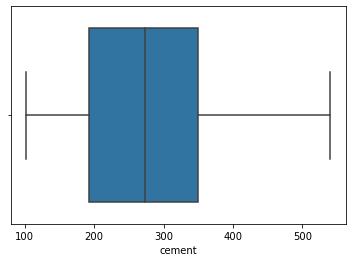

In [23]:
#Distribution of CEMENT

sns.boxplot(x='cement',data=df, orient='h')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

C:\Users\DELL\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<IPython.core.display.Javascript object>

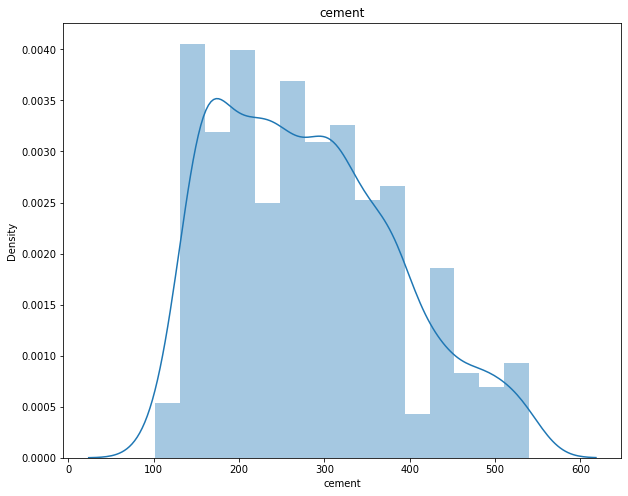

In [25]:
#displot

plt.figure(figsize=(10,8))
sns.distplot(df['cement']).set_title('cement')
plt.show()

### Water

In [26]:
#Quartiles

w_Q1=df['Water'].quantile(q=0.25)
w_Q3=df['Water'].quantile(q=0.75)

print('1st Quartile (Q1) is: ', w_Q1)
print('3rd Quartile (Q3) is: ', w_Q3)
print('Interquartile range (IQR) is: ', stats.iqr(df['Water']))

1st Quartile (Q1) is:  164.9
3rd Quartile (Q3) is:  192.0
Interquartile range (IQR) is:  27.099999999999994


In [28]:
#Outlier detection from Interquartile range (IQR) in original data

WL_outliers=w_Q1-1.5*(w_Q3-w_Q1)
WU_outliers=w_Q3+1.5*(w_Q3-w_Q1)

print('Lower outlier in water: ',WL_outliers)
print('Upper outlier in water: ',WU_outliers)

Lower outlier in water:  124.25000000000001
Upper outlier in water:  232.64999999999998


In [31]:
#Checking for presenece of outliers with the upper and lower limits

print('Number of outliers in water upper: ', df[df['Water']>232.64999999999998]['Water'].count())
print('Number of outliers in water lower: ', df[df['Water']<124.25000000000001]['Water'].count())

#print('% of Outlier in water upper: ', round(df[df['Water']>232.64999999999998]['Water'].count()*100/len(df)))
#print('% of Outlier in water lower: ', round(df[df['Water']<124.25000000000001]['Water'].count()*100/len(df)))

Number of outliers in water upper:  4
Number of outliers in water lower:  5


<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='Water'>

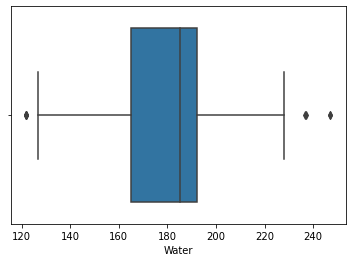

In [32]:
#Distribution of WATER

sns.boxplot(x='Water', data=df, orient='h')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

C:\Users\DELL\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<IPython.core.display.Javascript object>

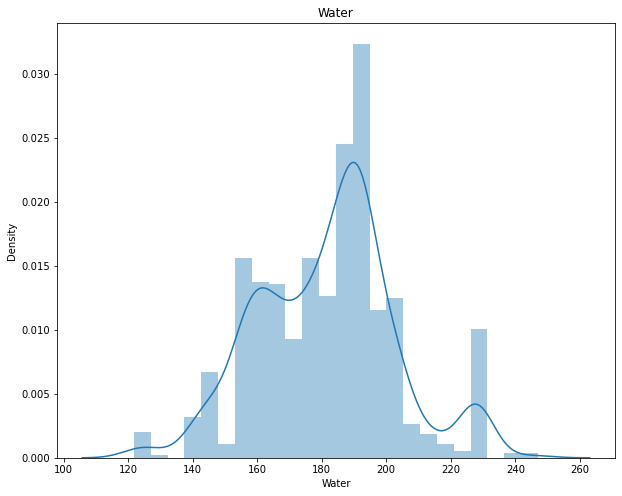

In [33]:
plt.figure(figsize=(10,8))
sns.distplot(df['Water']).set_title('Water')
plt.show()

### Slag

In [36]:
s_Q1=df['slag'].quantile(q=0.25)
s_Q3=df['slag'].quantile(q=0.75)

print('1st Quartile (Q1) is: ', s_Q1)
print('3rd Quartile (Q3) is: ', s_Q3)
print('Interquartile range (IQR) is: ', stats.iqr(df['slag']))

1st Quartile (Q1) is:  0.0
3rd Quartile (Q3) is:  142.95
Interquartile range (IQR) is:  142.95


In [37]:
#Outlier detection from Interquartile range (IQR) in original data

sL_outliers=Q1-1.5*(s_Q3-s_Q1)
sU_outliers=Q3+1.5*(s_Q3-s_Q1)

print('Lower outlier in water: ',sL_outliers)
print('Upper outlier in water: ',sU_outliers)

Lower outlier in water:  -214.42499999999998
Upper outlier in water:  357.375


In [38]:
#Checking for presenece of outliers with the upper and lower limits

print('Number of outliers in slag upper: ', df[df['slag']>357.375]['slag'].count())
print('Number of outliers in slag lower: ', df[df['slag']<-214.425]['slag'].count())

# print('% of Outlier in slag upper: ', round(df[df['slag']>357.375]['slag'].count()*100/len(df)))
# print('% of Outlier in slag lower: ', round(df[df['slag']<-214.425]['slag'].count()*100/len(df)))

Number of outliers in slag upper:  2
Number of outliers in slag lower:  0


<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='slag'>

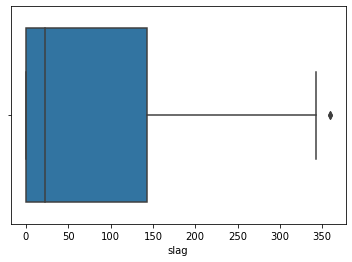

In [39]:
#Distribution of SLAG

sns.boxplot(x='slag', data=df, orient='h')

### Age

In [41]:
a_Q1=df['age'].quantile(q=0.25)
a_Q3=df['age'].quantile(q=0.75)

print('1st Quartile (Q1) is: ', a_Q1)
print('3rd Quartile (Q3) is: ', a_Q3)
print('Interquartile range (IQR) is: ', stats.iqr(df['age']))

1st Quartile (Q1) is:  7.0
3rd Quartile (Q3) is:  56.0
Interquartile range (IQR) is:  49.0


In [42]:
#Outlier detection from Interquartile range (IQR) in original data

aL_outliers=a_Q1-1.5*(a_Q3-a_Q1)
aU_outliers=a_Q3+1.5*(a_Q3-a_Q1)

print('Lower outlier in age: ',aL_outliers)
print('Upper outlier in age: ',aU_outliers)

Lower outlier in age:  -66.5
Upper outlier in age:  129.5


In [43]:
#Checking for presenece of outliers with the upper and lower limits

print('Number of outliers in age upper: ', df[df['age']>129.5]['age'].count())
print('Number of outliers in age lower: ', df[df['age']<-66.5]['age'].count())

Number of outliers in age upper:  59
Number of outliers in age lower:  0


<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='age'>

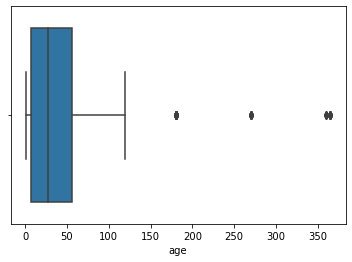

In [44]:
#Distribution of AGE

sns.boxplot(x='age', data=df, orient='h')

### Ash

In [54]:
aa_Q1=df['ash'].quantile(q=0.25)
aa_Q3=df['ash'].quantile(q=0.75)

print('1st Quartile (Q1) is: ', aa_Q1)
print('3rd Quartile (Q3) is: ', aa_Q3)
print('Interquartile range (IQR) is: ', stats.iqr(df['ash']))

1st Quartile (Q1) is:  0.0
3rd Quartile (Q3) is:  118.3
Interquartile range (IQR) is:  118.3


In [56]:
#Outlier detection from Interquartile range (IQR) in original data

aaL_outliers=aa_Q1-1.5*(aa_Q3-aa_Q1)
aaU_outliers=aa_Q3+1.5*(aa_Q3-aa_Q1)

print('Lower outlier in ash: ',aaL_outliers)
print('Upper outlier in ash: ',aaU_outliers)

Lower outlier in ash:  -177.45
Upper outlier in ash:  295.75


In [57]:
#Checking for presenece of outliers with the upper and lower limits

print('Number of outliers in ash upper: ', df[df['ash']>295.75]['ash'].count())
print('Number of outliers in ash lower: ', df[df['ash']<-177.45]['ash'].count())

Number of outliers in ash upper:  0
Number of outliers in ash lower:  0


<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='ash'>

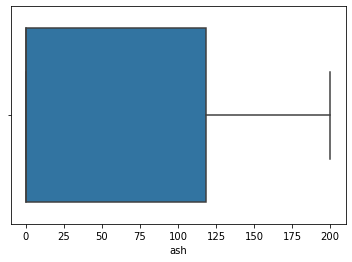

In [58]:
#Distribution of ASH

sns.boxplot(x='ash', data=df, orient='h')

### MultiVaariate Analysis

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

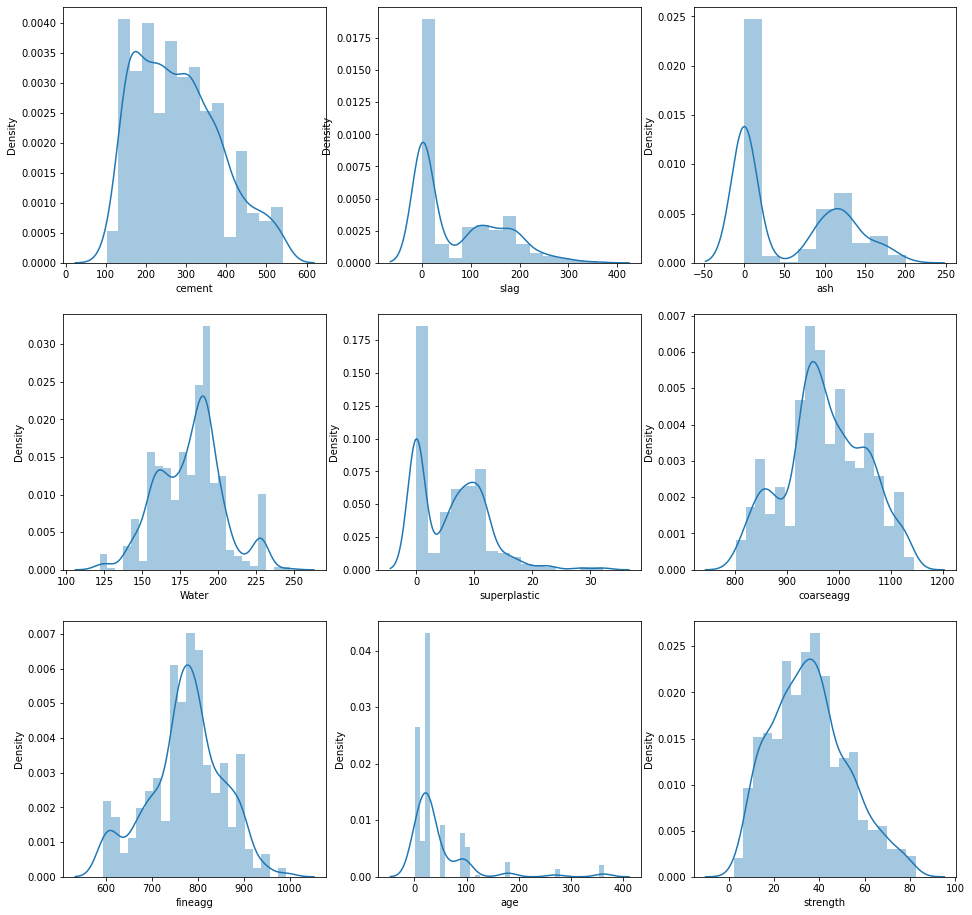

In [53]:
#Displot

fig,ax2 = plt.subplots(3,3,figsize=(16,16))
sns.distplot(df['cement'],ax=ax2[0][0])
sns.distplot(df['slag'],ax=ax2[0][1])
sns.distplot(df['ash'],ax=ax2[0][2])
sns.distplot(df['Water'],ax=ax2[1][0])
sns.distplot(df['superplastic'],ax=ax2[1][1])
sns.distplot(df['coarseagg'],ax=ax2[1][2])
sns.distplot(df['fineagg'],ax=ax2[2][0])
sns.distplot(df['age'],ax=ax2[2][1])
sns.distplot(df['strength'],ax=ax2[2][2])

import warnings
warnings.filterwarnings('ignore')


### Observations

We can observe that

1. Cement is almost norally distrubuted
2. Slag has 3 Guassians and rightly skewed
3. Ash has 2 Guassians and rightly skewed
4. Water has 3 Guassians and slightly left skewed
5. Super plastizer has 2 Guassians and rightly skewed
6. Coarse Agg has 3 Guassians and is almost norally distrubuted
7. Fine Agg has 2 Guassians and is almost norally distrubuted
5. Age has Multiple Guassians and rightly skewed

### Pairplot

<IPython.core.display.Javascript object>

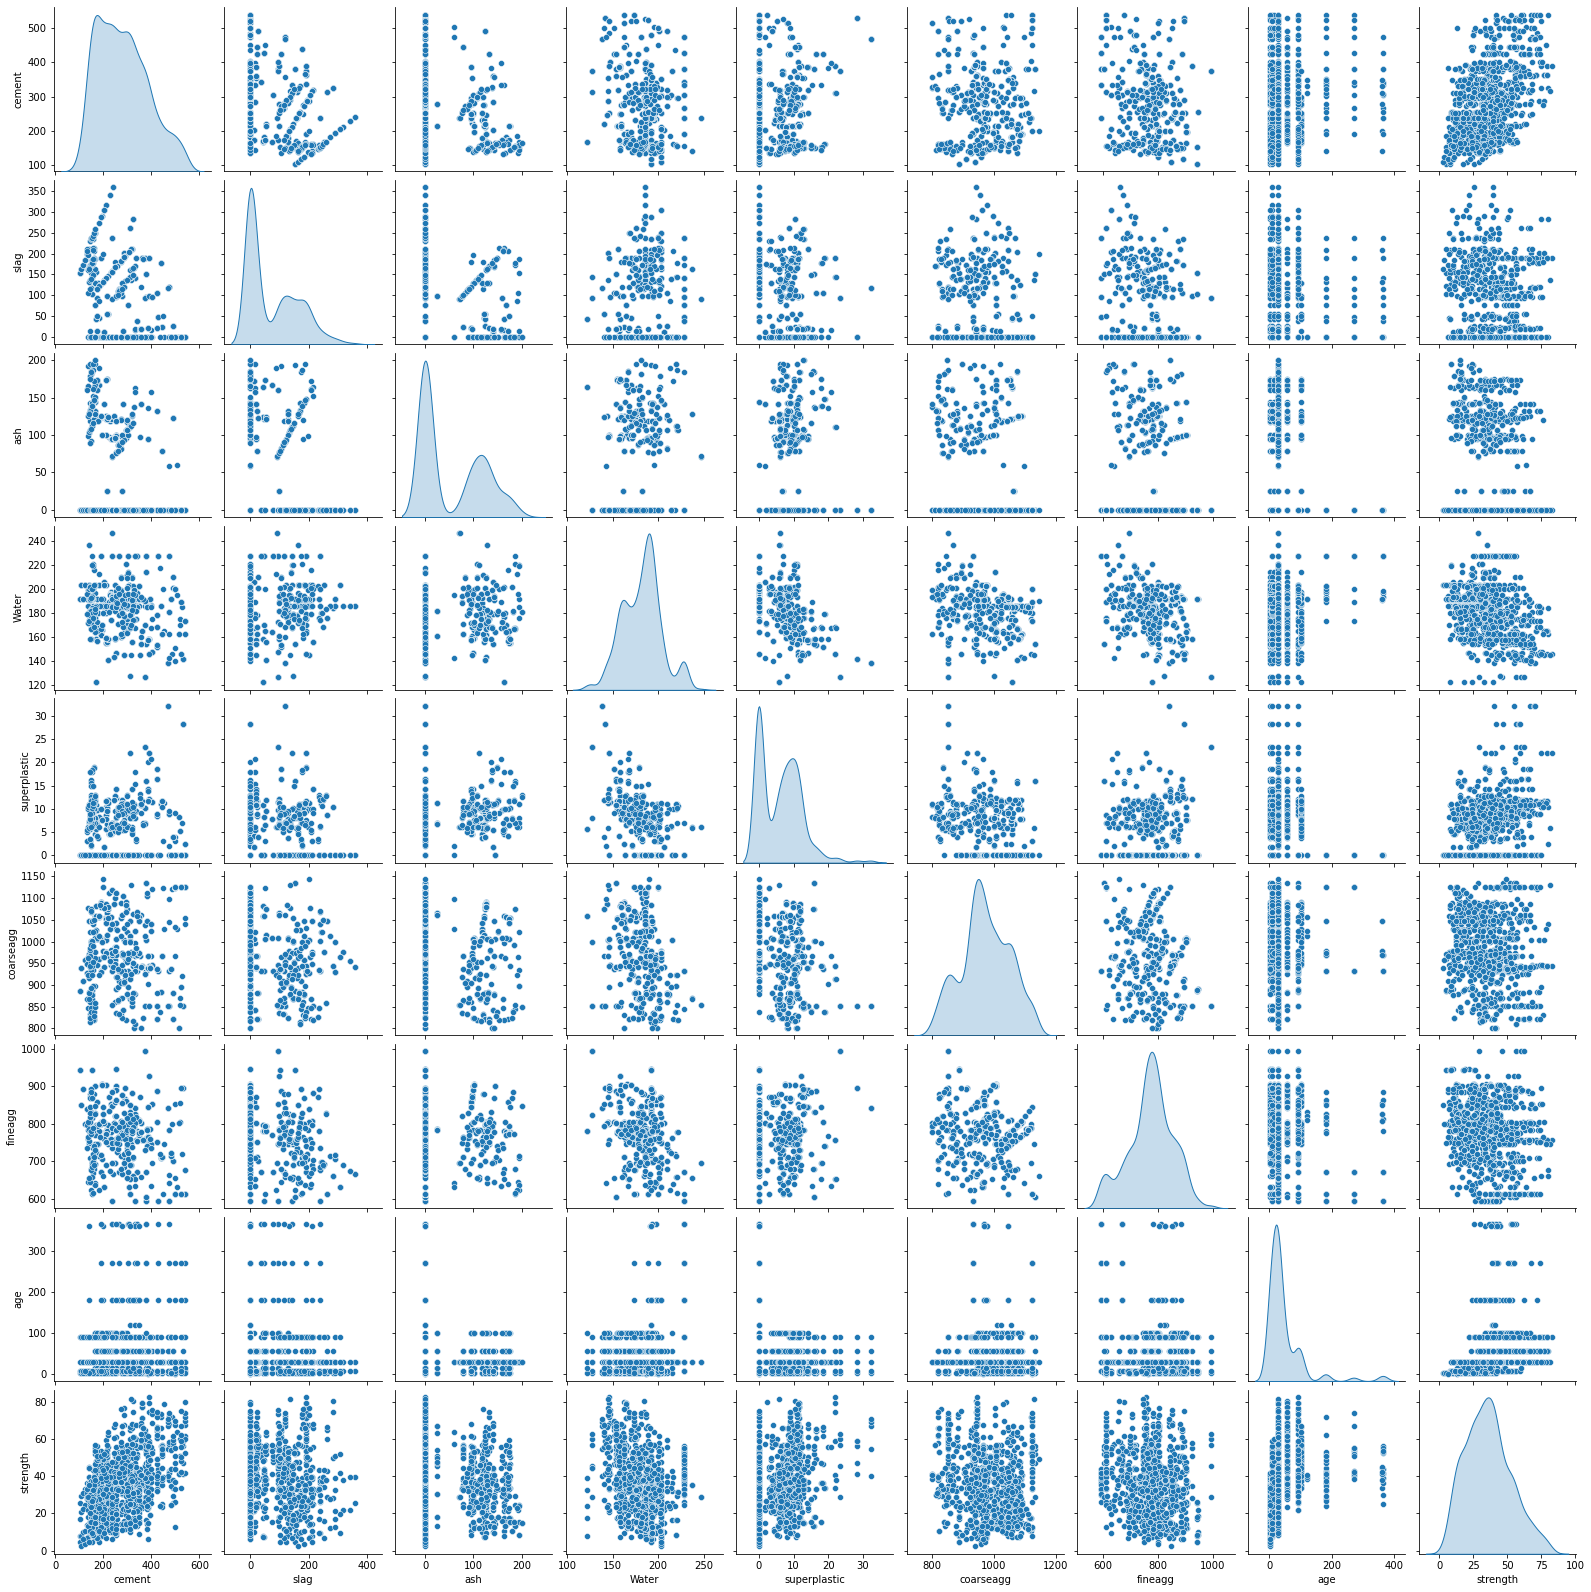

In [59]:
# pairplot.
#plot density curve instead of histogram in the diagonals

sns.pairplot(df, diag_kind='kde')

### Correlation between variables

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

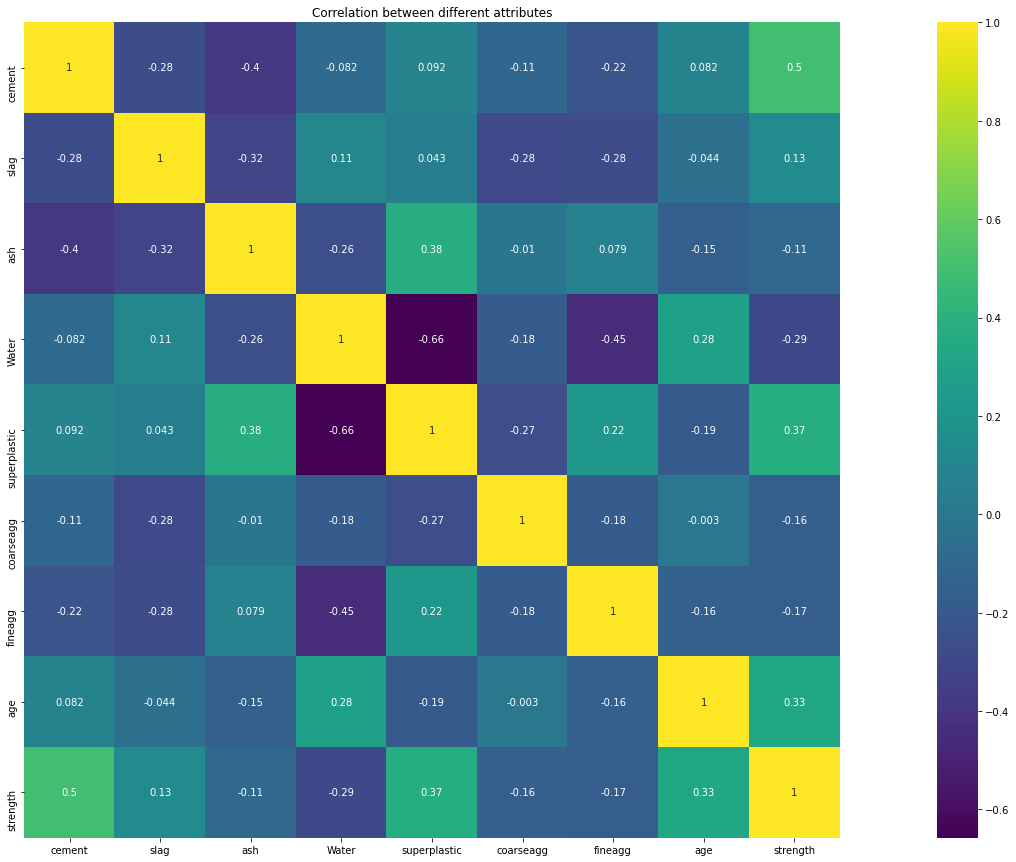

In [64]:
plt.figure(figsize=(35,15))

sns.heatmap(df.corr(),vmax=1, square=True, annot=True, cmap='viridis')
plt.title('Correlation between different attributes')
plt.show()

#### We can observe taht ther is no correlation between the particles of concrete

<AxesSubplot:>

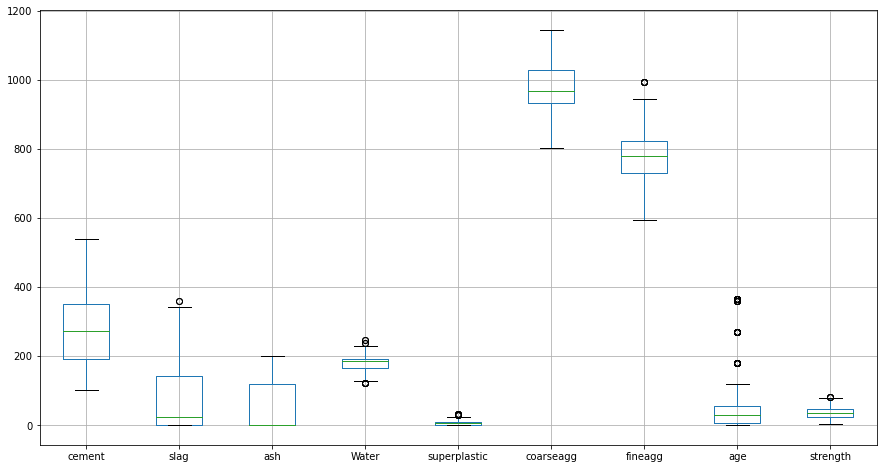

In [65]:
df.boxplot(figsize=(15,8))

#### we can observe all the outliers here

### Checking for outliers

In [66]:
print('Outliers in cement: ', df[((df.cement - df.cement.mean())/df.cement.std()).abs()>3]['cement'].count())
print('Outliers in slag: ', df[((df.slag - df.slag.mean())/df.slag.std()).abs()>3]['slag'].count())
print('Outliers in ash: ', df[((df.ash - df.ash.mean())/df.ash.std()).abs()>3]['ash'].count())
print('Outliers in water: ', df[((df.Water - df.Water.mean())/df.Water.std()).abs()>3]['Water'].count())
print('Outliers in superplastic: ', df[((df.superplastic - df.superplastic.mean())/df.superplastic.std()).abs()>3]['superplastic'].count())
print('Outliers in coarseagg: ', df[((df.coarseagg - df.coarseagg.mean())/df.coarseagg.std()).abs()>3]['coarseagg'].count())
print('Outliers in fineagg: ', df[((df.fineagg - df.fineagg.mean())/df.fineagg.std()).abs()>3]['fineagg'].count())
print('Outliers in age: ', df[((df.age - df.age.mean())/df.age.std()).abs()>3]['age'].count())

Outliers in cement:  0
Outliers in slag:  4
Outliers in ash:  0
Outliers in water:  2
Outliers in superplastic:  10
Outliers in coarseagg:  0
Outliers in fineagg:  0
Outliers in age:  33


### Replacing the outliers by median

In [67]:
for cols in df.columns[:-1]:
  Q1 = df[cols].quantile(0.25)
  Q3 = df[cols].quantile(0.75)
  iqr = Q3 - Q1

  low = Q1-1.5*iqr
  high = Q3+1.5*iqr
  df.loc[(df[cols] < low) | (df[cols] > high), cols] = df[cols].median()

<AxesSubplot:>

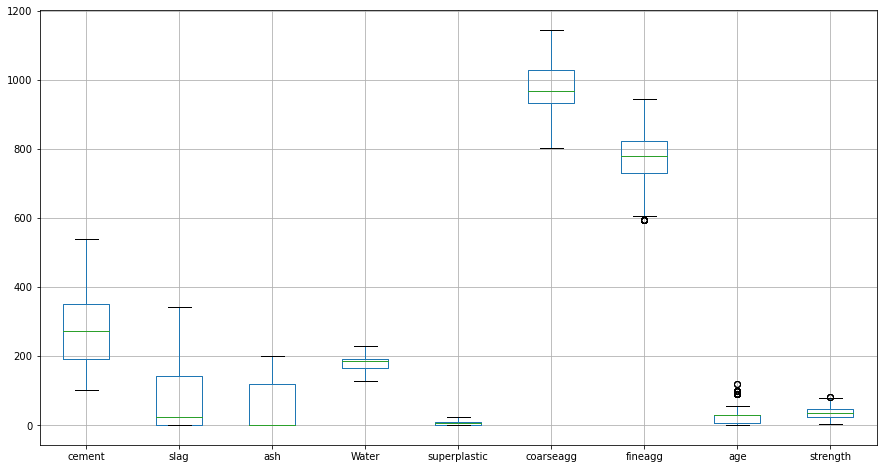

In [68]:
df.boxplot(figsize=(15,8)) #Check fot=r outliers again

#### We can observe that the outliers have been reduced

## Feature Engineering and Model Building


In [69]:
df.head()

,cement,slag,ash,Water,superplastic,coarseagg,fineagg,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,28,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,28,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,28,44.30


In [70]:
#Splitting the data into independent and dependent attributes


#independent and dependent variables
X = df.drop('strength', axis = 1)
y = df['strength']

In [72]:
from scipy.stats import zscore

Xscaled = X.apply(zscore)
Xscaled_df = pd.DataFrame(Xscaled, columns=df.columns)

<IPython.core.display.Javascript object>

###### The formula for calculating a z-score is is z = (x-μ)/σ
1. The value of the z-score tells you how many standard deviations you are away from the mean
2. The further away an observation's Z-score is from zero, the more unusual it is. A standard cut-off value for finding outliers are Z-scores of +/-3 or further from zero

In [73]:
X_train, X_test, y_train, y_test = train_test_split(Xscaled,y, test_size= 0.3, random_state= 1)

<IPython.core.display.Javascript object>

## Building different Models

### 1. Random Forest

In [74]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

<IPython.core.display.Javascript object>

RandomForestRegressor()

In [75]:
y_pred = model.predict(X_test)

In [76]:
#Model Performance on Training Data

model.score(X_train, y_train)

# round(model.score(X_train, y_train)*100) #if you want to get the exact percentage, uncomment this one

0.9811049155676256

In [77]:
#Model Performance on Test Data

model.score(X_test, y_test)

# round(model.score(X_test, y_test)*100) #if you want to get the exact percentage, uncomment this one

0.8775146538569785

In [78]:
#Same as above                  Model Performance on Test Data
acc_R=metrics.r2_score(y_test, y_pred)
acc_R

<IPython.core.display.Javascript object>

0.8775146538569785

In [79]:
metrics.mean_squared_error(y_test, y_pred)

<IPython.core.display.Javascript object>

32.10429099773612

##### 
1. The Mean Squared Error (MSE) or Mean Squared Deviation (MSD) of an estimator measures the average of error squares 
2. i.e. the average squared difference between the estimated values and true value
3. There is no correct value for MSE. Simply put, the lower the value the better and 0 means the model is perfect.

In [81]:
#Store the accuracy results for each model in a dataframe for final comparison

results_1 = pd.DataFrame({'Algorithm': ['Random Forest'], 'accuracy': acc_R},index={'1'})
results = results_1[['Algorithm','accuracy']]
results

<IPython.core.display.Javascript object>

,Algorithm,accuracy
1,Random Forest,0.877515


### 2. KFold Cross Validation

In [86]:
k = 20

kfold = KFold(n_splits=k, random_state=None, shuffle=False)
K_results = cross_val_score(model, X, y, cv=kfold)
accuracy=np.mean(abs(K_results))
accuracy

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.7537624040158275

In [87]:
#Store the accuracy results for each model in a dataframe for final comparison

random_re = pd.DataFrame({'Algorithm': ['Random Forest Regressor k_fold'], 'accuracy': accuracy},index={'2'})
results = pd.concat([results, random_re])
results = results[['Algorithm','accuracy']]
results

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Algorithm,accuracy
1,Random Forest,0.877515
2,Random Forest Regressor k_fold,0.753762


### Gradient Boosting Regressor

In [90]:
model = GradientBoostingRegressor()
model.fit(X_train, y_train)


<IPython.core.display.Javascript object>

GradientBoostingRegressor()

In [92]:
y_pred = model.predict(X_test)

In [93]:
#Model Performance on Training Data

model.score(X_train, y_train)

0.9477368610390589

In [94]:
#Model Performance on Test Data

model.score(X_test, y_test)

0.88041956609703

In [95]:
#Same as above, you can also store the above in a variable and use without doing the following.
acc_G=metrics.r2_score(y_test, y_pred)
acc_G

<IPython.core.display.Javascript object>

0.88041956609703

In [96]:
metrics.mean_squared_error(y_test, y_pred)

<IPython.core.display.Javascript object>

31.34289258711645

In [97]:
#Store the accuracy results for each model in a dataframe for final comparison

gradient_re = pd.DataFrame({'Algorithm': ['Gradient Boost Regressor'], 'accuracy': acc_G},index={'3'})
results = pd.concat([results, gradient_re])
results = results[['Algorithm','accuracy']]
results

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Algorithm,accuracy
1,Random Forest,0.877515
2,Random Forest Regressor k_fold,0.753762
3,Gradient Boost Regressor,0.880420


### K fold cross validation for Gradient Boosting Regressor

In [100]:
k = 20

kfold = KFold(n_splits=k, random_state=None)
results_3 = cross_val_score(model, X, y, cv=kfold)
accuracy=np.mean(abs(results_3))
accuracy

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.7710433470110563

In [101]:
#Store the accuracy results for each model in a dataframe for final comparison

gradient_k = pd.DataFrame({'Algorithm': ['Gradient Boost Regressor k fold'], 'accuracy': accuracy},index={'4'})
results = pd.concat([results, gradient_k])
results = results[['Algorithm','accuracy']]
results

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Algorithm,accuracy
1,Random Forest,0.877515
2,Random Forest Regressor k_fold,0.753762
3,Gradient Boost Regressor,0.880420
4,Gradient Boost Regressor k fold,0.771043


### Ada Boost Regressor

In [102]:
from sklearn.ensemble import AdaBoostRegressor

In [103]:
model = AdaBoostRegressor()
model.fit(X_train, y_train)

AdaBoostRegressor()

In [104]:
y_pred = model.predict(X_test)

In [105]:
#Model Performance on Test Data, NB: check on train data

model.score(X_test, y_test)

0.7491795369769898

#### the performance might vary when we run the notebook multiple, that's a normal scenario

In [106]:
#Same as above, you can also store the above in a variable and use without doing the following.
acc_Ada=metrics.r2_score(y_test, y_pred)
acc_Ada

<IPython.core.display.Javascript object>

0.7491795369769898

In [107]:
#Store the accuracy results for each model in a dataframe for final comparison

acc_Ada = pd.DataFrame({'Algorithm': ['Ada Boost Regressor'], 'accuracy': acc_Ada},index={'5'})
results = pd.concat([results, acc_Ada])
results = results[['Algorithm','accuracy']]
results

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Algorithm,accuracy
1,Random Forest,0.877515
2,Random Forest Regressor k_fold,0.753762
3,Gradient Boost Regressor,0.880420
4,Gradient Boost Regressor k fold,0.771043
5,Ada Boost Regressor,0.749180


### K fold cross Validation for Ada Boost

In [110]:
k = 20

kfold = KFold(n_splits=k, random_state=None)
results_4 = cross_val_score(model, X, y, cv=kfold)
accuracy=np.mean(abs(results_4))
accuracy

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.5856511513317171

In [111]:
#Store the accuracy results for each model in a dataframe for final comparison

acc_AdaC = pd.DataFrame({'Algorithm': ['Ada Boost Regressor k fold'], 'accuracy': accuracy},index={'6'})
results = pd.concat([results, acc_AdaC])
results = results[['Algorithm','accuracy']]
results

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Algorithm,accuracy
1,Random Forest,0.877515
2,Random Forest Regressor k_fold,0.753762
3,Gradient Boost Regressor,0.880420
4,Gradient Boost Regressor k fold,0.771043
5,Ada Boost Regressor,0.749180
6,Ada Boost Regressor k fold,0.585651


### KNN Regressor

In [112]:
#Checking for different values of neighbors to determine K
from sklearn.neighbors import KNeighborsRegressor


diff_k=[]
for i in range(1,45):
  knn = KNeighborsRegressor(n_neighbors=i)
  knn.fit(X_train, y_train)
  pred_i = knn.predict(X_test)
  diff_k.append(np.mean(pred_i != y_test))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0, 0.5, 'Mean errors')

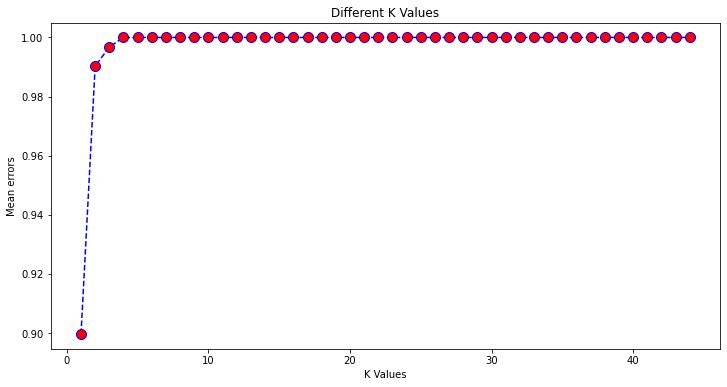

In [113]:
plt.figure(figsize=(12,6))
plt.plot(range(1,45),diff_k,color='blue',linestyle='dashed',marker='o',markerfacecolor='red',markersize=10)
plt.title('Different K Values')
plt.xlabel('K Values')
plt.ylabel('Mean errors')

#### from the figure we can observe that after the value of k = 3, the value of mean errors doesn't change significantly

In [114]:
#k=3 is a better choice from the above plot

model = KNeighborsRegressor(n_neighbors=3)
model.fit(X_train, y_train)


KNeighborsRegressor(n_neighbors=3)

In [115]:
y_pred = model.predict(X_test)

In [116]:
model.score(X_train, y_train)

0.9075702785732312

In [117]:
acc_KNN=metrics.r2_score(y_test, y_pred)
acc_KNN

<IPython.core.display.Javascript object>

0.7539494934126327

In [118]:
metrics.mean_squared_error(y_test, y_pred)

<IPython.core.display.Javascript object>

64.49160909744695

In [119]:
KNN_df = pd.DataFrame({'Algorithm':['KNN Regressor'], 'accuracy': [acc_KNN]}, index={'7'})
results = pd.concat([results, KNN_df])
results = results[['Algorithm','accuracy']]
results

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Algorithm,accuracy
1,Random Forest,0.877515
2,Random Forest Regressor k_fold,0.753762
3,Gradient Boost Regressor,0.880420
4,Gradient Boost Regressor k fold,0.771043
5,Ada Boost Regressor,0.749180
6,Ada Boost Regressor k fold,0.585651
7,KNN Regressor,0.753949


### KFold cross Validation for KNN Regressor


In [121]:
k = 20

kfold = KFold(n_splits=k, random_state=None)
results_5 = cross_val_score(model, X, y, cv=kfold)
accuracy=np.mean(abs(results_5))
accuracy

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.6907106255855276

In [122]:
#Store the accuracy results for each model in a dataframe for final comparison

KNNfold_df = pd.DataFrame({'Algorithm': ['KNN Regressor k fold'], 'accuracy': accuracy},index={'8'})
results = pd.concat([results, KNNfold_df])
results = results[['Algorithm','accuracy']]
results

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Algorithm,accuracy
1,Random Forest,0.877515
2,Random Forest Regressor k_fold,0.753762
3,Gradient Boost Regressor,0.880420
4,Gradient Boost Regressor k fold,0.771043
5,Ada Boost Regressor,0.749180
6,Ada Boost Regressor k fold,0.585651
7,KNN Regressor,0.753949
8,KNN Regressor k fold,0.690711


### Bagging Reggressor

In [123]:
from sklearn.ensemble import BaggingRegressor

model = BaggingRegressor()
model.fit(X_train,y_train)

BaggingRegressor()

In [124]:
y_pred = model.predict(X_test)

In [125]:
model.score(X_train, y_train)

0.9729753649460383

In [126]:
model.score(X_test, y_test)

0.8716742917323301

In [127]:
acc_BR=metrics.r2_score(y_test, y_pred)
acc_BR

<IPython.core.display.Javascript object>

0.8716742917323301

In [128]:
metrics.mean_squared_error(y_test, y_pred)

<IPython.core.display.Javascript object>

33.63509195545173

In [129]:
#Store the accuracy results for each model in a dataframe for final comparison

Bagging_df = pd.DataFrame({'Algorithm': ['Bagging Regressor'], 'accuracy': acc_BR},index={'9'})
results = pd.concat([results, Bagging_df])
results = results[['Algorithm','accuracy']]
results

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Algorithm,accuracy
1,Random Forest,0.877515
2,Random Forest Regressor k_fold,0.753762
3,Gradient Boost Regressor,0.880420
4,Gradient Boost Regressor k fold,0.771043
5,Ada Boost Regressor,0.749180
6,Ada Boost Regressor k fold,0.585651
7,KNN Regressor,0.753949
8,KNN Regressor k fold,0.690711
9,Bagging Regressor,0.871674


### KFold Validation for Bagging Regressor

In [131]:
k = 20

kfold = KFold(n_splits=k, random_state=None)
results_7 = cross_val_score(model, X, y, cv=kfold)
accuracy=np.mean(abs(results_7))
accuracy

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.7413468014487804

In [132]:
#Store the accuracy results for each model in a dataframe for final comparison

BaggingKFold_df = pd.DataFrame({'Algorithm': ['Bagging Regressor k fold'], 'accuracy': accuracy},index={'10'})
results = pd.concat([results, BaggingKFold_df])
results = results[['Algorithm','accuracy']]
results

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Algorithm,accuracy
1,Random Forest,0.877515
2,Random Forest Regressor k_fold,0.753762
3,Gradient Boost Regressor,0.880420
4,Gradient Boost Regressor k fold,0.771043
5,Ada Boost Regressor,0.749180
6,Ada Boost Regressor k fold,0.585651
7,KNN Regressor,0.753949
8,KNN Regressor k fold,0.690711
9,Bagging Regressor,0.871674
10,Bagging Regressor k fold,0.741347


### Support Vector Regressor

In [133]:
from sklearn.svm import SVR
model = SVR(kernel='linear')
model.fit(X_train, y_train)

SVR(kernel='linear')

In [134]:
y_pred = model.predict(X_test)

In [135]:
model.score(X_train, y_train)

0.7296525761559521

In [136]:
acc_SVR=metrics.r2_score(y_test, y_pred)
acc_SVR

<IPython.core.display.Javascript object>

0.6549962611822545

In [137]:
metrics.mean_squared_error(y_test, y_pred)

<IPython.core.display.Javascript object>

90.4279636306755

In [160]:
##Ver High error, so not suitable

In [138]:
#Store the accuracy results for each model in a dataframe for final comparison

SVR_df = pd.DataFrame({'Algorithm': ['Support Vector Regressor'], 'accuracy': acc_SVR},index={'11'})
results = pd.concat([results, SVR_df])
results = results[['Algorithm','accuracy']]
results

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Algorithm,accuracy
1,Random Forest,0.877515
2,Random Forest Regressor k_fold,0.753762
3,Gradient Boost Regressor,0.880420
4,Gradient Boost Regressor k fold,0.771043
5,Ada Boost Regressor,0.749180
6,Ada Boost Regressor k fold,0.585651
7,KNN Regressor,0.753949
8,KNN Regressor k fold,0.690711
9,Bagging Regressor,0.871674
10,Bagging Regressor k fold,0.741347


### KFold for SVR

In [139]:
k = 20

kfold = KFold(n_splits=k, random_state=None)
results_8 = cross_val_score(model, X, y, cv=kfold)
accuracy=np.mean(abs(results_8))
accuracy

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.615121115543553

In [140]:
#Store the accuracy results for each model in a dataframe for final comparison

SVRKFold_df = pd.DataFrame({'Algorithm': ['Support Vector Regressor k fold'], 'accuracy': accuracy},index={'12'})
results = pd.concat([results, SVRKFold_df])
results = results[['Algorithm','accuracy']]
results

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Algorithm,accuracy
1,Random Forest,0.877515
2,Random Forest Regressor k_fold,0.753762
3,Gradient Boost Regressor,0.880420
4,Gradient Boost Regressor k fold,0.771043
5,Ada Boost Regressor,0.749180
6,Ada Boost Regressor k fold,0.585651
7,KNN Regressor,0.753949
8,KNN Regressor k fold,0.690711
9,Bagging Regressor,0.871674
10,Bagging Regressor k fold,0.741347


### XGBoost Regressor

In [141]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
xgr = XGBRegressor()

xgr.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [142]:
y_pred = xgr.predict(X_test)

In [143]:
xgr.score(X_train, y_train)

0.9924341146964205

In [144]:
acc_XGB=metrics.r2_score(y_test, y_pred)
acc_XGB

<IPython.core.display.Javascript object>

0.9004226612596836

In [145]:
metrics.mean_squared_error(y_test, y_pred)

<IPython.core.display.Javascript object>

26.09993734243447

In [146]:
#Store the accuracy results for each model in a dataframe for final comparison

XGB_df = pd.DataFrame({'Algorithm': ['Support Vector Regressor'], 'accuracy': [acc_XGB]},index={'13'})
results = pd.concat([results, XGB_df])
results = results[['Algorithm','accuracy']]
results

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Algorithm,accuracy
1,Random Forest,0.877515
2,Random Forest Regressor k_fold,0.753762
3,Gradient Boost Regressor,0.880420
4,Gradient Boost Regressor k fold,0.771043
5,Ada Boost Regressor,0.749180
6,Ada Boost Regressor k fold,0.585651
7,KNN Regressor,0.753949
8,KNN Regressor k fold,0.690711
9,Bagging Regressor,0.871674
10,Bagging Regressor k fold,0.741347


### DesionTreeRegressor

In [147]:
from sklearn.tree import DecisionTreeRegressor

dec_model = DecisionTreeRegressor()
dec_model.fit(X_train, y_train)

DecisionTreeRegressor()

In [148]:
#printing the feature importance(that's features that are important and helping or contributing for us to make good predictions)
print('Feature importance: \n',pd.DataFrame(dec_model.feature_importances_,columns=['Importance'],index=X_train.columns))

<IPython.core.display.Javascript object>

Feature importance: 
               Importance
cement          0.309354
slag            0.058566
ash             0.008819
Water           0.121832
superplastic    0.050508
coarseagg       0.027992
fineagg         0.049968
age             0.372961


#### Cement, Age and Water are the most important features

In [149]:
y_pred = dec_model.predict(X_test)

In [150]:
dec_model.score(X_train, y_train)

0.9930841416603411

In [151]:
dec_model.score(X_test, y_test)

0.7679248982123011

In [152]:
acc_DT=metrics.r2_score(y_test, y_pred)
acc_DT

<IPython.core.display.Javascript object>

0.7679248982123011

In [153]:
#Store the accuracy results for each model in a dataframe for final comparison

DT_df = pd.DataFrame({'Algorithm': ['Decision Tree Regressor 1'], 'accuracy': [acc_DT]},index={'14'})
results = pd.concat([results, DT_df])
results = results[['Algorithm','accuracy']]
results

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Algorithm,accuracy
1,Random Forest,0.877515
2,Random Forest Regressor k_fold,0.753762
3,Gradient Boost Regressor,0.880420
4,Gradient Boost Regressor k fold,0.771043
5,Ada Boost Regressor,0.749180
6,Ada Boost Regressor k fold,0.585651
7,KNN Regressor,0.753949
8,KNN Regressor k fold,0.690711
9,Bagging Regressor,0.871674
10,Bagging Regressor k fold,0.741347


### KFold for Decision Tree Regressor

######https://towardsdatascience.com/why-and-how-to-cross-validate-a-model-d6424b45261f

Notes about K Cross Validation

In [158]:
k = 20

kfold = KFold(n_splits=k, random_state=None)
results_9 = cross_val_score(dec_model, X, y, cv=kfold)
accuracy=np.mean(abs(results_9))
accuracy

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.6130611157809513

In [159]:
#Store the accuracy results for each model in a dataframe for final comparison

DCT_df = pd.DataFrame({'Algorithm': ['Decision Tree Regressor k fold'], 'accuracy': accuracy},index={'15'})
results = pd.concat([results, DCT_df])
results = results[['Algorithm','accuracy']]
results

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Algorithm,accuracy
1,Random Forest,0.877515
2,Random Forest Regressor k_fold,0.753762
3,Gradient Boost Regressor,0.880420
4,Gradient Boost Regressor k fold,0.771043
5,Ada Boost Regressor,0.749180
6,Ada Boost Regressor k fold,0.585651
7,KNN Regressor,0.753949
8,KNN Regressor k fold,0.690711
9,Bagging Regressor,0.871674
10,Bagging Regressor k fold,0.741347


# Feature Selection

###### from DecisionTreeRegressor
Feature importance: 
               Importance
1. cement----------------          0.309354
2. slag ----------------              0.058566
3. ash   ----------------             0.008819
4. Water    ----------------          0.121832
5. superplastic ----------------      0.050508
6. coarseagg----------------          0.027992
7. fineagg ----------------           0.049968
8. age    ----------------            0.372961

In [161]:
df2 = df.copy() #create a copy of df in order to drop the least important features and work on only the important features

In [162]:
X = df2.drop(['strength','ash','coarseagg','fineagg'],axis=1)
y = df2['strength']
#Split the X and y into training and test set in 70:30 ratio
X_train,X_test, y_train,y_test = train_test_split(X,y, test_size=0.3,random_state = 1)

<IPython.core.display.Javascript object>

In [163]:
X_train = X_train.apply(zscore)
X_test = X_test.apply(zscore)

In [164]:
decNew_Model = DecisionTreeRegressor()
decNew_Model.fit(X_train, y_train)

DecisionTreeRegressor()

In [165]:
#printing the feature importance
#(that's features that are important and helping or contributing for us to make good predictions)
print('Feature importance: \n',pd.DataFrame(decNew_Model.feature_importances_,columns=['Importance'],index=X_train.columns))

<IPython.core.display.Javascript object>

Feature importance: 
               Importance
cement          0.350818
slag            0.074851
Water           0.139617
superplastic    0.057589
age             0.377125


In [166]:
y_pred = decNew_Model.predict(X_test)

In [167]:
decNew_Model.score(X_train, y_train)

0.9911889880235539

In [168]:
decNew_Model.score(X_test, y_test)

0.7343428441050883

In [169]:
acc_DT=metrics.r2_score(y_test, y_pred)
acc_DT

<IPython.core.display.Javascript object>

0.7343428441050883

In [170]:
#Store the accuracy results for each model in a dataframe for final comparison

DT_df = pd.DataFrame({'Algorithm': ['Decision Tree Regressor 2'], 'accuracy': [acc_DT]},index={'16'})
results = pd.concat([results, DT_df])
results = results[['Algorithm','accuracy']]
results

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Algorithm,accuracy
1,Random Forest,0.877515
2,Random Forest Regressor k_fold,0.753762
3,Gradient Boost Regressor,0.880420
4,Gradient Boost Regressor k fold,0.771043
5,Ada Boost Regressor,0.749180
6,Ada Boost Regressor k fold,0.585651
7,KNN Regressor,0.753949
8,KNN Regressor k fold,0.690711
9,Bagging Regressor,0.871674
10,Bagging Regressor k fold,0.741347


In [171]:
#Let's create our training and testing data again since it has been overriden

X=df.drop('strength',axis=1)
y=df['strength']

In [172]:
Xscaled=X.apply(zscore)
Xscaled_df=pd.DataFrame(Xscaled,columns=df.columns)

<IPython.core.display.Javascript object>

In [173]:
#Split the X and y into training and test set in 70:30 ratio
X_train,X_test, y_train,y_test = train_test_split(Xscaled,y, test_size=0.3,random_state = 1)

<IPython.core.display.Javascript object>

In [174]:
dec_prun_model=DecisionTreeRegressor(max_depth=4, random_state=1,min_samples_leaf=5)
dec_prun_model.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=4, min_samples_leaf=5, random_state=1)

In [175]:
#printing the feature importance(that's features that are important and helping or contributing for us to make good predictions)
print('Feature importance: \n',pd.DataFrame(dec_prun_model.feature_importances_,columns=['Importance'],index=X_train.columns))

<IPython.core.display.Javascript object>

Feature importance: 
               Importance
cement          0.355615
slag            0.000000
ash             0.000000
Water           0.106034
superplastic    0.035409
coarseagg       0.000000
fineagg         0.025055
age             0.477887


In [190]:
feature_cols 


Index(['cement', 'slag', 'ash', 'Water', 'superplastic', 'coarseagg',
       'fineagg', 'age'],
      dtype='object')

In [191]:
y_pred = dec_prun_model.predict(X_test)

In [192]:
#On Training data
dec_prun_model.score(X_train, y_train)

0.7578225840644413

In [193]:
#On testing data

dec_prun_model.score(X_test, y_test)

0.556820999525816

In [194]:
acc_DecT=metrics.r2_score(y_test, y_pred)
acc_DecT

<IPython.core.display.Javascript object>

0.556820999525816

In [195]:
metrics.mean_squared_error(y_test, y_pred)

<IPython.core.display.Javascript object>

116.16040647585388

##### VERY High MSE error, so ignote the prunned DecisionTreeModel

In [196]:
#Store the accuracy results for each model in a dataframe for final comparison

DecT_df = pd.DataFrame({'Algorithm': ['Pruned Decision Tree'], 'accuracy': [acc_DecT]},index={'17'})
results = pd.concat([results, DecT_df])
results = results[['Algorithm','accuracy']]
results

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Algorithm,accuracy
1,Random Forest,0.877515
2,Random Forest Regressor k_fold,0.753762
3,Gradient Boost Regressor,0.880420
4,Gradient Boost Regressor k fold,0.771043
5,Ada Boost Regressor,0.749180
6,Ada Boost Regressor k fold,0.585651
7,KNN Regressor,0.753949
8,KNN Regressor k fold,0.690711
9,Bagging Regressor,0.871674
10,Bagging Regressor k fold,0.741347


## *Gradient Boost Regressor, Support Vector Regressor, Bagging Regressor* and Random Forest seems to do well in the scenario. We can choose either of them.

### Furthert Study: You can again drop the features that are not important and rebuild the models again(consider doing hyperparameter tuning using GridSearchCV)